# Data extraction and analysis for OpenDengue
### Author: Hailey Robertson
### Created date: 2024-09-24
### Last updated: 2024-11-13
### Citations:
- Clarke J, Lim A, Gupte P, Pigott DM, van Panhuis WG, Brady OJ. A global dataset of publicly available dengue case count data. Sci Data. 2024 Mar 14;11(1):296.
- Clarke J, Lim A, Gupte P, Pigott DM, van Panhuis WG, Brady OJ. OpenDengue: data from the OpenDengue database. Version [1.2]. figshare; 2023. Available from: https://doi.org/10.6084/m9.figshare.24259573.


### DONE 
- find NAs at adm2 and adm1 compared to adm0 (8% missing adm1, 44% missing adm2)
- zero-filling – zeroes were most likely previously NAs, but not necessarily 
- dates to dates
- floats to floats
- match on iso3
- observed reporting period differences (1 year, 30 days, 1 week)
- combined place column + geocode


## Imports and constants

In [16]:
# Imports
import requests
import pandas as pd
from datetime import datetime
import os
import numpy as np
import geopandas as gpd
import country_converter as coco
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
from matplotlib import font_manager
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import silhouette_score
from brokenaxes import brokenaxes
from geopy.geocoders import Nominatim
from shapely.geometry import MultiPolygon
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from collections import defaultdict
import pickle
import time
from dotenv import load_dotenv

load_dotenv()

False

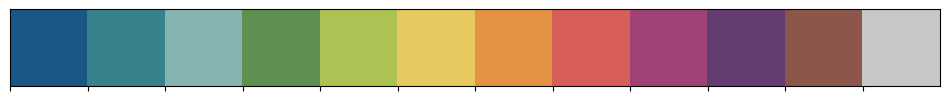

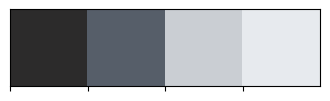

In [2]:
colors = ['#1A5784', '#38828C', '#84B5B2', '#60904F', '#ACC253', '#E7C960', '#E49243', '#D75F58', '#A04275', '#633D71', '#8c564b', '#c7c7c7']
sns.palplot(sns.color_palette(colors))

# Define chart color palette
chart = ['#2C2B2B','#565E69','#CACED3','#E7EAEE']
sns.palplot(sns.color_palette(chart))

# Define constants
figure_size = (20,6)

# Set background
sns.set_context('talk') #change the size from small to medium
sns.set_style('white') #change bg to white

# Add every font at the specified location
font_dir = ['/Users/haileyrobertson/Library/Fonts']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)
    
# Set font family globally
plt.rcParams['font.family'] = 'Open Sans'
plt.rcParams['font.weight'] = 'bold'

# Set margins
plt.rcParams['axes.xmargin'] = 0.1
plt.rcParams['axes.ymargin'] = 0.1

# Define list of date formats
zfmts = ['', '%Y','%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']

# Format axes 
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.titlepad'] = 30

# Format ticks
plt.rcParams["xtick.direction"] = "out"
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 10
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.color'] = chart[2]
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['xtick.labelcolor'] = chart[1]
plt.rcParams['xtick.labelsize'] = 8

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.pad"] = 0
plt.rcParams["ytick.minor.pad"] = 0
plt.rcParams["ytick.major.size"] = 10
plt.rcParams["ytick.minor.size"] = 10
plt.rcParams["ytick.color"] = chart[2]
plt.rcParams["ytick.major.width"] = 0.1
plt.rcParams["ytick.minor.width"] = 0.1
plt.rcParams["ytick.labelcolor"] = chart[1]
plt.rcParams["ytick.labelsize"] = 8


# Adjust fontdict for title
titlefont = {'family': 'Open Sans',
             'color':  chart[0], 
             'weight': 400,
             'size': 20}

# Set grid style
plt.rcParams['grid.color'] = chart[2]
plt.rcParams['grid.linestyle'] = 'dashed'
plt.rcParams['grid.linewidth']=0.5

# Set legend style
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125



# Set axis labels
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.labelcolor'] = chart[1]

## Cleaning

In [3]:
# Get data from master repo, reset index to access adm_0_name
url = 'https://raw.githubusercontent.com/OpenDengue/master-repo/refs/heads/main/data/raw_data/masterDB_V1.2.csv'
df = pd.read_csv(url, index_col=0, encoding='latin-1').reset_index()

# Convert unstandardized country names into iso3 codes
df["adm_0_iso3"] = coco.convert(names=df["adm_0_name"],to='ISO3', not_found="missing")

# Convert all date columns to datetime
date_cols = ['calendar_start_date', 'calendar_end_date']
df[date_cols] = df[date_cols].apply(pd.to_datetime)

df.head()

,adm_0_name,adm_0_code,adm_1_name,adm_1_code,adm_2_name,adm_2_code,calendar_start_date,calendar_end_date,dengue_total,case_definition_standardised,UUID,adm_0_iso3
0,Argentina,12.0,Salta,445.0,Oran,4781.0,2019-07-21,2019-07-27,2.0,Total,MOH-ARG-2019-Y01-00,ARG
1,Argentina,12.0,Misiones,442.0,Iguazu,4728.0,2019-09-01,2019-09-07,1.0,Total,MOH-ARG-2019-Y01-00,ARG
2,Argentina,12.0,Salta,445.0,Grl. Jose De San Martin,4773.0,2019-07-14,2019-07-20,1.0,Total,MOH-ARG-2019-Y01-00,ARG
3,Argentina,12.0,Jujuy,438.0,Ledesma,4649.0,2019-07-14,2019-07-20,1.0,Total,MOH-ARG-2019-Y01-00,ARG
4,Argentina,12.0,Salta,445.0,Grl. Jose De San Martin,4773.0,2019-06-30,2019-07-06,3.0,Total,MOH-ARG-2019-Y01-00,ARG


In [4]:
# Check for missing iso3 (should be empty)
missing_rows = df[df["adm_0_iso3"] == "missing"]
if len(missing_rows) == 0:
    print("No missing values!")
else:
    print(missing_rows)

country_dict = dict(zip(df['adm_0_iso3'], df['adm_0_name']))

# Group by 'adm_0_iso3' and filter groups with more than one unique 'adm_0_name'
duplicates = df.groupby('adm_0_iso3').filter(lambda x: x['adm_0_name'].nunique() > 1)

# Get the iso3 codes that have more than one country name
problematic_iso3_codes = duplicates['adm_0_iso3'].unique()

open_dengue_list = df['adm_0_iso3'].unique()
print("Unique ISO3 codes:", len(country_dict))
print("ISO3 codes with multiple names:", problematic_iso3_codes)

No missing values!
Unique ISO3 codes: 102
ISO3 codes with multiple names: ['DOM' 'PER' 'USA' 'VCT' 'KNA' 'ATG' 'TCA' 'TTO' 'MYS' 'FSM' 'MNP' 'PCN'
 'VNM' 'WLF']


In [32]:
# World geometry shapefile, devastating that get_path("naturalearth_lowres") was deprecated 
world = gpd.read_file("../data/ne_110m_admin_0_countries")
# print(world.columns.tolist())
world = world.rename(columns={"ADM0_A3":"adm_0_iso3",
                              "ADMIN":"adm_0_name",
                              "REGION_UN":"region_un",
                              "geometry":"adm_0_geometry"})
cols = ['adm_0_iso3','adm_0_name','region_un','adm_0_geometry']
world = world[cols]
world = world.sort_values(by="adm_0_name")

# Fix known issues
# # Start with France / GUF
world.loc[world['adm_0_name'] == 'France', 'adm_0_iso3'] = 'FRA'
france_row = world.loc[world['adm_0_name'] == 'France']
france_geom = france_row['adm_0_geometry'].values[0]

if isinstance(france_geom, MultiPolygon):
    polygons = list(france_geom.geoms)

    french_guiana_polygon = None
    for poly in polygons:
        # Check the bounds to find the polygon for French Guiana
        if poly.bounds[0] < -50 and poly.bounds[2] > -54:  
            french_guiana_polygon = poly
            break

    if french_guiana_polygon:
        french_guiana_row = {
            'adm_0_iso3': 'GUF',  # ISO3 code for French Guiana
            'adm_0_name': 'French Guiana',
            'region_un': 'Americas',
            'adm_0_geometry': french_guiana_polygon
        }

        french_guiana_gdf = gpd.GeoDataFrame([french_guiana_row])

        # Set the geometry column for the new GeoDataFrame (important for operations like concat)
        french_guiana_gdf.set_geometry('adm_0_geometry', inplace=True)

        french_guiana_gdf = gpd.GeoDataFrame([french_guiana_row])

        # Remove French Guiana's polygon from France's row
        remaining_polygons = [poly for poly in polygons if poly != french_guiana_polygon]
        france_row.loc[france_row.index, 'adm_0_geometry'] = MultiPolygon(remaining_polygons)
        world.loc[world['adm_0_name'] == 'France', 'adm_0_geometry'] = france_row['adm_0_geometry'].values[0]

        # Step 5: Use pd.concat to add the new row to world GeoDataFrame
        world = gpd.GeoDataFrame(pd.concat([world, french_guiana_gdf], ignore_index=True))
        world.set_geometry('adm_0_geometry', inplace=True)

world.loc[world['adm_0_name'] == 'Norway', 'adm_0_iso3'] = 'NOR'
world.loc[world['adm_0_name'] == 'Somaliland', 'adm_0_iso3'] = 'SOM'
world.loc[world['adm_0_name'] == 'Kosovo', 'adm_0_iso3'] = 'RKS'
world.loc[world['adm_0_name'] == 'South Sudan', 'adm_0_iso3'] = 'SSD'


world.head()


,adm_0_iso3,adm_0_name,region_un,adm_0_geometry
0,AFG,Afghanistan,Asia,"POLYGON ((66.51861 37.36278, 67.07578 37.35614..."
1,ALB,Albania,Europe,"POLYGON ((21.02004 40.84273, 20.99999 40.58, 2..."
2,DZA,Algeria,Africa,"POLYGON ((-8.6844 27.39574, -8.66512 27.58948,..."
3,AGO,Angola,Africa,"MULTIPOLYGON (((12.99552 -4.7811, 12.63161 -4...."
4,ATA,Antarctica,Antarctica,"MULTIPOLYGON (((-48.66062 -78.04702, -48.1514 ..."


In [33]:
# Merge geometry, keeping nulls
open_dengue = pd.merge(df,world,on='adm_0_iso3',how='outer')

# Fill adm_0_name_x with values from adm_0_name_y if it is empty
open_dengue['adm_0_name'] = open_dengue['adm_0_name_x'].where(open_dengue['adm_0_name_x'].notna() & (open_dengue['adm_0_name_x'] != ''), open_dengue['adm_0_name_y'])

# Drop the original _x and _y columns
open_dengue = open_dengue.drop(columns=['adm_0_name_x', 'adm_0_name_y'])

# Move adm_0_name and adm_0_iso3 to the front
columns = ['adm_0_name', 'adm_0_iso3'] + [col for col in open_dengue.columns if col not in ['adm_0_name', 'adm_0_iso3']]
open_dengue = open_dengue[columns]

print("Number of ISO3 codes: ", len(open_dengue.adm_0_iso3.unique()))
print("regions: ", open_dengue.region_un.unique())

Number of ISO3 codes:  220
regions:  [nan 'Asia' 'Africa' 'Europe' 'Americas' 'Antarctica' 'Oceania']


In [34]:
# Check UN region
missing_un_region = open_dengue[open_dengue['region_un'].isna()]
print(missing_un_region.adm_0_name.unique())
# Fill with 'Other' for now
open_dengue['region_un'] = open_dengue['region_un'].fillna("Other")

['Aruba' 'Anguilla' 'American Samoa' 'Antigua and Barbuda'
 'Antigua And Barbuda' 'Bonaire, Saint Eustatius and Saba'
 'Saint Barthelemy' 'Bermuda' 'Barbados' 'Cook Islands' 'Curacao'
 'Cayman Islands' 'Dominica' 'Micronesia (Federated States Of)' 'FSM'
 'Micronesia (Federated States of)' 'Guadeloupe' 'Grenada' 'Guam'
 'Hong Kong' 'Kiribati' 'Saint Kitts and Nevis' 'Saint Kitts And Nevis'
 'Saint Lucia' 'Macau' 'Saint Martin' 'Maldives' 'Marshall Islands'
 'Northern Mariana Islands' 'N Mariana Is' 'Montserrat' 'Martinique'
 'Niue' 'Nauru' 'Pitcairn' 'Pitcairn Islands' 'Palau' 'French Polynesia'
 'Singapore' 'Sint Maarten' 'Turks and Caicos Islands'
 'Turks And Caicos Islands' 'Tokelau' 'Tonga' 'Tuvalu'
 'Saint Vincent and the Grenadines' 'Saint Vincent And The Grenadines'
 'Virgin Islands (UK)' 'Virgin Islands (US)' 'Wallis And Futuna'
 'Wallis and Futuna' 'Wallis & Futuna' 'Samoa']


In [35]:
# Extract year from calendar_start_date
open_dengue['year'] = open_dengue['calendar_start_date'].dt.year

#  Not all periods are the same length – some places report every year, some every month, some every week
open_dengue["date_diff"] = (open_dengue["calendar_end_date"] - open_dengue["calendar_start_date"]).dt.days

# Find geo resolution and combine places
def highest_geo_resolution(row):
    if pd.notna(row['adm_2_name']) and row['adm_2_name'] != '':
        return 'adm_2'
    elif pd.notna(row['adm_1_name']) and row['adm_1_name'] != '':
        return 'adm_1'
    else:
        return 'adm_0'

open_dengue['geo_resolution'] = open_dengue.apply(highest_geo_resolution, axis=1)

open_dengue['combined_place'] = open_dengue[['adm_2_name', 'adm_1_name', 'adm_0_name']].apply(
    lambda x: ', '.join([str(place) for place in x if pd.notna(place) and place != '']), axis=1)

## Export

In [36]:
# # Save the DataFrame as a CSV file – too big to commit!
# open_dengue.to_csv("../data/open_dengue_v1_2.csv", index=False)

## Analysis

### Temporal and geographic resolution

In [37]:
# Create the figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# First subplot: Number of rows by reporting period

trying = pd.Categorical(open_dengue['date_diff'])
reporting_period_counts = pd.Series(trying).value_counts().sort_index()
# reporting_period_counts = open_dengue['date_diff'].value_counts().sort_index()

bars = ax1.bar(reporting_period_counts.index.astype(str), reporting_period_counts.values, color = colors[1], width = 1)

# Adding height labels above each bar
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', fontsize=8, color=chart[1])


ax1.set_title('Temporal resolution')
ax1.set_xlabel('Reporting period (days)')
ax1.set_ylabel('Number of rows')

# Second subplot: Number of rows by geographic resolution
geo_resolution_counts = open_dengue['geo_resolution'].value_counts()
bars2 = ax2.bar(geo_resolution_counts.index, geo_resolution_counts.values, color=colors[1])

for bar2 in bars2:
    height = bar2.get_height()
    ax2.text(bar2.get_x() + bar2.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', fontsize=8, color=chart[1])

ax2.set_title('Geographic resolution')
ax2.set_xlabel('Administrative level')
ax2.set_ylabel('Number of rows')

# Display the plots
plt.tight_layout()
filename = f"../output/figures/data_coverage/open_dengue_temp_geo_coverage_1950-2023_all.png"  # Replace spaces with underscores for safe filenames
plt.savefig(filename, format='png', dpi=300)
plt.close()

### Data coverage over time

#### Roll up to country level and year

In [38]:
# Fill the years so that ISO3s stay
years = pd.Series(range(int(1950), int(open_dengue['year'].max()) + 1))
unique_iso3 = open_dengue['adm_0_iso3'].unique()

all_combinations = pd.MultiIndex.from_product([unique_iso3, years], names=['adm_0_iso3', 'year']).to_frame(index=False)

open_dengue_rollup = all_combinations.merge(open_dengue, on=['adm_0_iso3', 'year'], how='outer')

# List of columns to fill
columns_to_fill = ['adm_0_name', 'region_un', 'adm_0_geometry', 'geo_resolution', 'combined_place']

# Fill NaN values for multiple columns
open_dengue_rollup[columns_to_fill] = (
    open_dengue_rollup
    .groupby('adm_0_iso3')[columns_to_fill]
    .transform(lambda x: x.ffill().bfill())
)

open_dengue_rollup = open_dengue_rollup.dropna(subset=['year'])

print(len(open_dengue_rollup.adm_0_iso3.unique()))

open_dengue_rollup.head()

220


,adm_0_iso3,year,adm_0_name,adm_0_code,adm_1_name,adm_1_code,adm_2_name,adm_2_code,calendar_start_date,calendar_end_date,dengue_total,case_definition_standardised,UUID,region_un,adm_0_geometry,date_diff,geo_resolution,combined_place
0,ABW,1950.0,Aruba,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,Other,None,NaN,adm_0,Aruba
1,ABW,1951.0,Aruba,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,Other,None,NaN,adm_0,Aruba
2,ABW,1952.0,Aruba,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,Other,None,NaN,adm_0,Aruba
3,ABW,1953.0,Aruba,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,Other,None,NaN,adm_0,Aruba
4,ABW,1954.0,Aruba,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,Other,None,NaN,adm_0,Aruba


#### UN member region dictionary

In [39]:
# Creating the dictionary with ISO3 codes as keys and regions as values - this is UN member states by region
countries = {
    "DZA": "African States", "SWZ": "African States", "NAM": "African States",
    "AGO": "African States", "ETH": "African States", "NER": "African States",
    "BEN": "African States", "GAB": "African States", "NGA": "African States",
    "BWA": "African States", "GMB": "African States", "RWA": "African States",
    "BFA": "African States", "GHA": "African States", "STP": "African States",
    "BDI": "African States", "GIN": "African States", "SEN": "African States",
    "CPV": "African States", "GNB": "African States", "SYC": "African States",
    "CMR": "African States", "KEN": "African States", "SLE": "African States",
    "CAF": "African States", "LSO": "African States", "SOM": "African States",
    "TCD": "African States", "LBR": "African States", "ZAF": "African States",
    "COM": "African States", "LBY": "African States", "SSD": "African States",
    "COG": "African States", "MDG": "African States", "SDN": "African States",
    "CIV": "African States", "MWI": "African States", "TGO": "African States",
    "COD": "African States", "MLI": "African States", "TUN": "African States",
    "DJI": "African States", "MRT": "African States", "UGA": "African States",
    "EGY": "African States", "MUS": "African States", "TZA": "African States",
    "GNQ": "African States", "MAR": "African States", "ZMB": "African States",
    "ERI": "African States", "MOZ": "African States", "ZWE": "African States",
    
    "AFG": "Asia-Pacific States", "KGZ": "Asia-Pacific States", "WSM": "Asia-Pacific States",
    "BHR": "Asia-Pacific States", "LAO": "Asia-Pacific States", "SAU": "Asia-Pacific States",
    "BGD": "Asia-Pacific States", "LBN": "Asia-Pacific States", "SGP": "Asia-Pacific States",
    "BTN": "Asia-Pacific States", "MYS": "Asia-Pacific States", "SLB": "Asia-Pacific States",
    "BRN": "Asia-Pacific States", "MDV": "Asia-Pacific States", "LKA": "Asia-Pacific States",
    "KHM": "Asia-Pacific States", "MHL": "Asia-Pacific States", "SYR": "Asia-Pacific States",
    "CHN": "Asia-Pacific States", "FSM": "Asia-Pacific States", "TKM": "Asia-Pacific States",
    "CYP": "Asia-Pacific States", "MNG": "Asia-Pacific States", "THA": "Asia-Pacific States",
    "PRK": "Asia-Pacific States", "MMR": "Asia-Pacific States", "TLS": "Asia-Pacific States",
    "FJI": "Asia-Pacific States", "NRU": "Asia-Pacific States", "TON": "Asia-Pacific States",
    "IND": "Asia-Pacific States", "NPL": "Asia-Pacific States", "TUR": "Asia-Pacific States",
    "IDN": "Asia-Pacific States", "OMN": "Asia-Pacific States", "TKM": "Asia-Pacific States",
    "IRN": "Asia-Pacific States", "PAK": "Asia-Pacific States", "TUV": "Asia-Pacific States",
    "IRQ": "Asia-Pacific States", "PLW": "Asia-Pacific States", "ARE": "Asia-Pacific States",
    "JPN": "Asia-Pacific States", "PNG": "Asia-Pacific States", "UZB": "Asia-Pacific States",
    "JOR": "Asia-Pacific States", "PHL": "Asia-Pacific States", "VUT": "Asia-Pacific States",
    "KAZ": "Asia-Pacific States", "QAT": "Asia-Pacific States", "VNM": "Asia-Pacific States",
    "KIR": "Asia-Pacific States", "KOR": "Asia-Pacific States", "YEM": "Asia-Pacific States",
    "KWT": "Asia-Pacific States",
    
    "ALB": "Eastern European States", "EST": "Eastern European States", "MDA": "Eastern European States",
    "ARM": "Eastern European States", "GEO": "Eastern European States", "ROU": "Eastern European States",
    "AZE": "Eastern European States", "HUN": "Eastern European States", "RUS": "Eastern European States",
    "BLR": "Eastern European States", "LVA": "Eastern European States", "SRB": "Eastern European States",
    "BIH": "Eastern European States", "LTU": "Eastern European States", "SVK": "Eastern European States",
    "BGR": "Eastern European States", "MNE": "Eastern European States", "SVN": "Eastern European States",
    "HRV": "Eastern European States", "MKD": "Eastern European States", "UKR": "Eastern European States",
    "CZE": "Eastern European States", "POL": "Eastern European States",
    
    "ATG": "Latin American and Caribbean States", "DMA": "Latin American and Caribbean States", "NIC": "Latin American and Caribbean States",
    "ARG": "Latin American and Caribbean States", "DOM": "Latin American and Caribbean States", "PAN": "Latin American and Caribbean States",
    "BHS": "Latin American and Caribbean States", "ECU": "Latin American and Caribbean States", "PRY": "Latin American and Caribbean States",
    "BRB": "Latin American and Caribbean States", "SLV": "Latin American and Caribbean States", "PER": "Latin American and Caribbean States",
    "BLZ": "Latin American and Caribbean States", "GRD": "Latin American and Caribbean States", "KNA": "Latin American and Caribbean States",
    "BOL": "Latin American and Caribbean States", "GTM": "Latin American and Caribbean States", "LCA": "Latin American and Caribbean States",
    "BRA": "Latin American and Caribbean States", "GUY": "Latin American and Caribbean States", "VCT": "Latin American and Caribbean States",
    "CHL": "Latin American and Caribbean States", "HTI": "Latin American and Caribbean States", "SUR": "Latin American and Caribbean States",
    "COL": "Latin American and Caribbean States", "HND": "Latin American and Caribbean States", "TTO": "Latin American and Caribbean States",
    "CRI": "Latin American and Caribbean States", "JAM": "Latin American and Caribbean States", "URY": "Latin American and Caribbean States",
    "CUB": "Latin American and Caribbean States", "MEX": "Latin American and Caribbean States", "VEN": "Latin American and Caribbean States",
    
    "AND": "Western European and other States", "ISL": "Western European and other States", "NOR": "Western European and other States",
    "AUS": "Western European and other States", "IRL": "Western European and other States", "PRT": "Western European and other States",
    "AUT": "Western European and other States", "ISR": "Western European and other States", "SMR": "Western European and other States",
    "BEL": "Western European and other States", "ITA": "Western European and other States", "ESP": "Western European and other States",
    "CAN": "Western European and other States", "LIE": "Western European and other States", "SWE": "Western European and other States",
    "DNK": "Western European and other States", "LUX": "Western European and other States", "CHE": "Western European and other States",
    "FIN": "Western European and other States", "MLT": "Western European and other States", "TUR": "Western European and other States",
    "FRA": "Western European and other States", "MCO": "Western European and other States", "GBR": "Western European and other States",
    "DEU": "Western European and other States", "NLD": "Western European and other States", "USA": "Western European and other States",
    "GRC": "Western European and other States", "NZL": "Western European and other States"
}

#### Create dengue_pop DFs and calc incidence

In [40]:
# Merge with population size per year
pop = pd.read_csv("../data/WPP2022_Demographic_Indicators_Medium.csv", dtype={'Time': float,'TPopulation1July':float}, low_memory=False)
columns = ['ISO3_code','Time','TPopulation1July']
pop = pop[columns]

dengue_pop = open_dengue_rollup.merge(pop,left_on=['adm_0_iso3','year'],right_on=['ISO3_code','Time'],how='outer')
dengue_pop.drop(columns[:-1],axis=1,inplace=True)
dengue_pop = dengue_pop.dropna(subset=['adm_0_iso3'])

# NOTE: Do this separately because adm_0_geometry has fewer countries available
dengue_pop_geo = dengue_pop.groupby(['adm_0_iso3', 'year','region_un','TPopulation1July','adm_0_geometry']).agg({
    'dengue_total': 'sum'
}).reset_index()

dengue_pop = dengue_pop.groupby(['adm_0_iso3', 'year','region_un','TPopulation1July']).agg({
    'dengue_total': 'sum'
}).reset_index()

dfs = [dengue_pop_geo, dengue_pop]

for df in dfs:
    # Calculate incidence
    df['TPopulation1July'] = df['TPopulation1July'] * 1000
    df['incidence'] = df['dengue_total'] / dengue_pop['TPopulation1July']
    df['incidence_per_100k'] = df['incidence'] * 100000
    df['log_incidence_per_100k'] = np.log1p(df['incidence_per_100k'])  # log(x + 1) to handle zero values

    # Mess with this at some point
    df['rolling_mean_4yr'] = df.groupby('adm_0_iso3')['log_incidence_per_100k'].rolling(window=4, min_periods=1).mean().reset_index(level=0, drop=True)

    df['year'] = dengue_pop['year'].astype(int)

    # Updating the 'region_un' column based on the iso3_code
    df['region_un'] = df['adm_0_iso3'].map(countries).fillna("Other")

print(len(dengue_pop.adm_0_iso3.unique()))
dengue_pop.head()

213


,adm_0_iso3,year,region_un,TPopulation1July,dengue_total,incidence,incidence_per_100k,log_incidence_per_100k,rolling_mean_4yr
0,ABW,1950,Other,38798.0,0.0,0.0,0.0,0.0,0.0
1,ABW,1951,Other,40231.0,0.0,0.0,0.0,0.0,0.0
2,ABW,1952,Other,41758.0,0.0,0.0,0.0,0.0,0.0
3,ABW,1953,Other,43305.0,0.0,0.0,0.0,0.0,0.0
4,ABW,1954,Other,44869.0,0.0,0.0,0.0,0.0,0.0


#### Regional mapping - UN member states

##### Plot - any coverage

In [41]:
heatmap_data = dengue_pop.pivot(index='adm_0_iso3', columns='year', values='incidence').fillna(0)

binary_heatmap_data = np.where(heatmap_data == 0, 0, 1)

binary_heatmap_data = pd.DataFrame(binary_heatmap_data, index=dengue_pop['adm_0_iso3'].unique(), columns=dengue_pop['year'].unique())

binary_heatmap_data = binary_heatmap_data.sort_index()

binary_heatmap_data

# Plot

fig, ax = plt.subplots(figsize=(20, 45))  # Adjust size as needed

custom_colors = ["white", colors[1]]


# Plot the heatmap
im = sns.heatmap(data=binary_heatmap_data, cmap=custom_colors, annot=False, fmt='g', linewidths=0.5, ax=ax, vmin=0, vmax=1, cbar=False)

# Set tick labels and axis labels
ax.set_xlabel('Year')
ax.set_ylabel('Country')
ax.set_title("Data Coverage Over Time",loc='left')

# Set tick parameters
ax.tick_params(axis='x', pad=5, length=0, labelsize=10, width=30)
plt.setp(ax.get_xticklabels(), rotation=90)

ax.tick_params(axis='y', pad=10, width=30, labelsize=10)
ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)

# Hide spines
ax.spines.bottom.set_visible(False)
ax.spines.left.set_visible(False)

# Set title and show the plot
plt.tight_layout()
filename = f"../output/figures/data_coverage/open_dengue_coverage_1950-2023_all.png"  # Replace spaces with underscores for safe filenames
plt.savefig(filename, format='png', dpi=300)
plt.close()

##### Plot - regional coverage

In [42]:
# Get unique regions
regions = dengue_pop['region_un'].unique()

# Custom color settings
custom_colors = ["white", colors[1]]  # Example colors (adjust as needed)

# Loop through each region and create an individual plot
for region in regions:
    # Filter the heatmap data by region
    region_data = dengue_pop[dengue_pop['region_un'] == region].pivot(index='adm_0_iso3', columns='year', values='incidence').fillna(0)
    binary_region_data = np.where(region_data == 0, 0, 1)
    binary_region_data = pd.DataFrame(binary_region_data, index=region_data.index, columns=region_data.columns)    
    
    # Create a new figure for each region
    plt.figure(figsize=(10, 6))
    
    # Plot the heatmap
    sns.heatmap(data=binary_region_data, cmap=custom_colors, annot=False, fmt='g', linewidths=0.5, vmin=0, vmax=1, cbar=False)
    
    # Set labels and title
    plt.title(f"Data Coverage Over Time - {region}", loc='left')
    plt.ylabel('Country')
    plt.xlabel('Year')
    
    # Customize tick parameters for readability
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    
    # Adjust layout for better spacing
    plt.tight_layout()

    # Save each plot with a unique filename based on the region
    filename = f"../output/figures/data_coverage/open_dengue_coverage_1950-2023_{region.replace(' ', '_')}.png"  # Replace spaces with underscores for safe filenames
    plt.savefig(filename, format='png', dpi=300)
    
    # Close the plot to free up memory
    plt.close()

### Incidence over time

#### Plot - regional (all countries)

In [43]:
# Define a custom colormap that uses white for 0 and rocket_r for >0
rocket_r_cmap = sns.color_palette("rocket_r", as_cmap=True)
custom_cmap = ListedColormap(["white"] + list(rocket_r_cmap(np.linspace(0.01, 1, 256))))

# Get unique regions
regions = dengue_pop['region_un'].unique()

# Loop through each region and create an individual plot
for region in regions:
    # Filter the heatmap data by region
    region_data = dengue_pop[dengue_pop['region_un'] == region].pivot(index='adm_0_iso3', columns='year', values='incidence_per_100k').fillna(0)
    heatmap_region_data = pd.DataFrame(region_data, index=region_data.index, columns=region_data.columns)
    
    # Create a new figure for each region
    plt.figure(figsize=(14, 14))
    
    # Plot the heatmap with the custom color map
    sns.heatmap(
        data=heatmap_region_data,
        cmap=custom_cmap,
        annot=False,
        fmt='g',
        linewidths=0.5,
        vmin=0,
        vmax=1000,  
        cbar=True,
        cbar_kws={'orientation': 'horizontal', 'pad': 0.07, 'label':'Incidence rate per 100,000'}
    )
    
    # Set labels and title
    plt.title(f"Annual incidence (per 100,000)- {region}", loc='left')
    plt.ylabel('Country')
    plt.xlabel('Year')
    
    # Customize tick parameters for readability
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    
    # Save each plot with a unique filename based on the region
    filename = f"../output/figures/incidence/regional/open_dengue_incidence_1950-2023_{region.replace(' ', '_')}.png"  # Replace spaces with underscores for safe filenames
    plt.savefig(filename, format='png', dpi=300)
    
    # Close the plot to free up memory
    plt.close()


#### Create any_dengue df (countries ever reporting incidence > 0)

In [44]:
# Find unique countries that have ever had incidence > 0
countries_with_incidence = dengue_pop[dengue_pop['incidence'] > 0]['adm_0_iso3'].unique()

# Filter the DataFrame to include only rows for these countries
any_dengue = dengue_pop[dengue_pop['adm_0_iso3'].isin(countries_with_incidence)]
any_dengue.sort_values(by=["adm_0_iso3", "year"], ascending=[True, True], inplace=True)

any_dengue_list = any_dengue.adm_0_iso3.unique()
print(len(any_dengue.adm_0_iso3.unique()))
print(any_dengue.adm_0_iso3.unique())

101
['ABW' 'AFG' 'AIA' 'ARG' 'ASM' 'ATG' 'AUS' 'BES' 'BGD' 'BHS' 'BLM' 'BLZ'
 'BMU' 'BOL' 'BRA' 'BRB' 'BRN' 'BTN' 'CHL' 'CHN' 'COK' 'COL' 'CRI' 'CUB'
 'CUW' 'CYM' 'DMA' 'DOM' 'ECU' 'FJI' 'FSM' 'GLP' 'GRD' 'GTM' 'GUF' 'GUM'
 'GUY' 'HKG' 'HND' 'HTI' 'IDN' 'IND' 'JAM' 'JPN' 'KHM' 'KIR' 'KNA' 'LAO'
 'LCA' 'LKA' 'MAC' 'MAF' 'MDV' 'MEX' 'MHL' 'MMR' 'MNG' 'MNP' 'MSR' 'MTQ'
 'MYS' 'NCL' 'NIC' 'NIU' 'NPL' 'NRU' 'PAK' 'PAN' 'PER' 'PHL' 'PLW' 'PNG'
 'PRI' 'PRY' 'PYF' 'SAU' 'SDN' 'SGP' 'SLB' 'SLV' 'SUR' 'SXM' 'TCA' 'THA'
 'TKL' 'TLS' 'TON' 'TTO' 'TUV' 'TWN' 'URY' 'USA' 'VCT' 'VEN' 'VGB' 'VIR'
 'VNM' 'VUT' 'WLF' 'WSM' 'YEM']


/var/folders/xw/zd1n0pds56ng1c2mc9r21pvr0000gn/T/ipykernel_59098/2276131358.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  any_dengue.sort_values(by=["adm_0_iso3", "year"], ascending=[True, True], inplace=True)


In [45]:
# figure out why open dengue finds 102 countries and i find 101
diff = [item for item in open_dengue_list if item not in any_dengue_list]
print(diff) # Pitcairn Islands - they always report 0 cases?

['PCN']


#### Plot - incidence in countries ever reporting dengue (heatmap)

In [46]:
heatmap_data = any_dengue.pivot(index='adm_0_iso3', columns='year', values='incidence_per_100k').fillna(0)

# Define a custom colormap that uses white for 0 and rocket_r for >0
rocket_r_cmap = sns.color_palette("rocket_r", as_cmap=True)
custom_cmap = ListedColormap(["white"] + list(rocket_r_cmap(np.linspace(0.01, 1, 256))))

# Plot
fig, ax = plt.subplots(figsize=(14, 14))  # Adjust size as needed

custom_colors = ["white", colors[1]]


# Plot the heatmap
im = sns.heatmap(data=heatmap_data, 
                 cmap=custom_cmap, 
                 annot=False, 
                 fmt='g', 
                 linewidths=0.5, 
                 ax=ax, 
                 vmin=0, 
                 vmax=1000, 
                 cbar=True, 
                 cbar_kws={'orientation': 'horizontal', 'pad': 0.07, 'label':'Incidence rate per 100,000'})

# Set tick labels and axis labels
ax.set_xlabel('Year')
ax.set_ylabel('Country')
ax.set_title("Incidence rate per 100,000 over time (among countries with reporting)",loc='left')

# Set tick parameters
ax.tick_params(axis='x', pad=5, length=0, labelsize=10, width=30)
plt.setp(ax.get_xticklabels(), rotation=90)

ax.tick_params(axis='y', pad=10, width=30, labelsize=10, rotation=0)
ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)

# Hide spines
ax.spines.bottom.set_visible(False)
ax.spines.left.set_visible(False)

# Set title and show the plot
plt.tight_layout()
filename = f"../output/figures/incidence/global/open_dengue_incidence_1950-2023_all_reporting.png"
plt.savefig(filename, format='png', dpi=300)
plt.close()

#### Plot - incidence in countries ever reporting dengue (1 plot per country)

In [ ]:
country_codes = any_dengue['adm_0_iso3'].unique()

# Loop through each country and create a plot
for country in country_codes:
    # Filter data for the current country
    country_data = any_dengue[any_dengue['adm_0_iso3'] == country]
    
    # Plot incidence per 100k over time
    plt.figure(figsize=(10, 6))
    plt.plot(country_data['year'][:-1], country_data['incidence_per_100k'][:-1], label=f'Incidence per 100k', color=colors[0], linewidth=2)
    
    # Adding labels and title
    plt.xlabel('Year')
    plt.ylabel('Incidence per 100k')
    plt.ylim(0, country_data['incidence_per_100k'].max() * 1.1)  # 10% buffer on top
    plt.title(f'Incidence per 100k over time for {country}',loc='left')
    
    # Add gridlines
    plt.grid(True, axis='y')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 0.97))
    
    plt.tight_layout()
    filename = f"../output/figures/incidence/country/open_dengue_incidence_1950-2022_{country}.png"
    plt.savefig(filename, format='png', dpi=300)
    plt.close()


#### Plot - global incidence (rolled up, ever reporting)

##### Create global_totals df

In [47]:
# Group by year and calculate global sums - NOTE, this is the sum of all countrys ever reporting NOT global total pop...
global_totals = any_dengue.groupby('year').agg({
    'dengue_total': 'sum',
    'TPopulation1July': 'sum'
}).reset_index()

# Calculate the global incidence per 100k population
global_totals['incidence'] = (global_totals['dengue_total'] / global_totals['TPopulation1July'])
global_totals['incidence_per_100k'] = (global_totals['dengue_total'] / global_totals['TPopulation1July'])*100000
global_totals['log_incidence_per_100k'] = np.log1p(global_totals['incidence_per_100k'])


# Display the result
global_totals.tail()


,year,dengue_total,TPopulation1July,incidence,incidence_per_100k,log_incidence_per_100k
69,2019,6934847.0,5.238320e+09,0.001324,132.386861,4.893254
70,2020,3163603.0,5.277392e+09,0.000599,59.946334,4.109994
71,2021,1902379.0,5.310327e+09,0.000358,35.824138,3.606154
72,2022,3549012.0,5.340891e+09,0.000664,66.449808,4.211384
73,2023,82854.0,5.374670e+09,0.000015,1.541564,0.932780


##### Plot - line chart global incidence totals

In [48]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the data
plt.plot(global_totals['year'][:-1], global_totals['log_incidence_per_100k'][:-1], label='log(incidence per 100k)', color = colors[0], linewidth = 2, zorder=10)

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('log(incidence per 100k)')
plt.title('Total incidence in countries ever reporting dengue cases', loc='left')

# Calculate the line of best fit
x = global_totals['year'][:-1]
y = global_totals['log_incidence_per_100k'][:-1]
slope, intercept = np.polyfit(x, y, 1)  
best_fit_line = slope * x + intercept

# Calculate R^2
y_pred = best_fit_line
ss_total = np.sum((y - np.mean(y))**2)
ss_residual = np.sum((y - y_pred)**2)
r_squared = 1 - (ss_residual / ss_total)

# Plot the line of best fit
plt.plot(x, best_fit_line, color=colors[6], linestyle=':', label=f'Line of best fit (R² = {r_squared:.3f})',zorder=1)

plt.legend(loc='upper right', bbox_to_anchor=(1.36, 0.98), handlelength=2)
plt.grid(True, axis='y')

plt.tight_layout()
filename = f"../output/figures/incidence/global/open_dengue_global_log_incidence_1950-2022_all_reporting.png"
plt.savefig(filename, format='png', dpi=300)
plt.close()


##### Plot - global case count totals

In [50]:
fig, ax = plt.subplots(figsize=(14, 6))

# Plotting the data
plt.plot(global_totals['year'][:-1], global_totals['dengue_total'][:-1], label='Total cases', color = colors[0], linewidth = 2, zorder=10)

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Total cases')
plt.ylim(0,7000000)
plt.title('Incident cases in countries ever reporting dengue cases', loc='left')


# Function to format y-axis labels
def full_number(x, pos):
    return f'{int(x):,}'  

ax.yaxis.set_major_formatter(FuncFormatter(full_number))

# Calculate the line of best fit
x = global_totals['year'][:-1]
y = global_totals['dengue_total'][:-1]
slope, intercept = np.polyfit(x, y, 1)  
best_fit_line = slope * x + intercept

# Calculate R^2
y_pred = best_fit_line
ss_total = np.sum((y - np.mean(y))**2)
ss_residual = np.sum((y - y_pred)**2)
r_squared = 1 - (ss_residual / ss_total)

# Plot the line of best fit
plt.plot(x, best_fit_line, color=colors[6], linestyle=':', label=f'Line of best fit (R² = {r_squared:.3f})',zorder=1)

plt.legend(loc='upper right', bbox_to_anchor=(1.28, 1.05), handlelength=2)
plt.grid(True, axis='y')

plt.tight_layout()
filename = f"../output/figures/incidence/global/open_dengue_global_cases_1950-2022_all_reporting.png"
plt.savefig(filename, format='png', dpi=300)
plt.close()

##### Perform differencing - plot to see autocorrelation (incidence)

In [ ]:
# Perform differencing (subtract the previous value from the current value)
global_totals['diff_incidence'] = global_totals['log_incidence_per_100k'].diff()

# Remove the first NaN value created by differencing
global_totals_diff = global_totals.dropna()

# Create a subplot with 2 rows and 2 columns
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the original and differenced data
ax.plot(global_totals_diff['year'][:-1], global_totals_diff['log_incidence_per_100k'][:-1], label='Original data', color=colors[0])
ax.plot(global_totals_diff['year'][:-1], global_totals_diff['diff_incidence'][:-1], label='Differenced data', color= colors[7])
ax.set_xlabel('Year')
ax.set_ylabel('log(incidence per 100k)')
ax.set_title('Original vs differenced incidence of dengue globally (where reported)', loc='left')
ax.legend(loc='upper right',bbox_to_anchor=[1.21,1])

plt.tight_layout()
filename = f"../output/figures/autocorrelation/open_dengue_global_autocorrelation_log_incidence_1950-2022_all_reporting.png"
plt.savefig(filename, format='png', dpi=300)
plt.close()

##### ACF and PACF (incidence)

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6))

# Plot the ACF of the original data
plot_acf(global_totals_diff['log_incidence_per_100k'][:-1], lags=20, ax=ax[0, 0])
ax[0, 0].set_title('ACF of original data')
ax[0, 0].set_ylim(None, 1.05)

# Display the PACF of the original data
plot_pacf(global_totals_diff['log_incidence_per_100k'][:-1], lags=20, ax=ax[0, 1])
ax[0, 1].set_title('PACF of original data')
ax[0, 1].set_ylim(None, 1.05)

# Plot the ACF of the differenced data
plot_acf(global_totals_diff['diff_incidence'][:-1], lags=20, ax=ax[1, 0])
ax[1, 0].set_title('ACF of differenced data')
ax[1, 0].set_ylim(None, 1.05)

# Plot the PACF of the differenced data
plot_pacf(global_totals_diff['diff_incidence'][:-1], lags=20, ax=ax[1, 1])
ax[1, 1].set_title('PACF of differenced data')
ax[1, 1].set_ylim(None, 1.05)

for axi in ax.flat:
    axi.set_xlabel('Lag')

# Adjust layout to avoid overlap
plt.tight_layout()
filename = f"../output/figures/autocorrelation/open_dengue_global_log_incidence_acf_pacf.png"
plt.savefig(filename, format='png', dpi=300)
plt.close()

##### Differencing - autocorrelation (case counts)

In [ ]:
# Perform differencing (subtract the previous value from the current value)
global_totals['diff_cases'] = global_totals['dengue_total'].diff()

# Remove the first NaN value created by differencing
global_totals_diff = global_totals.dropna()

# Create a subplot with 2 rows and 2 columns
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the original and differenced data
ax.plot(global_totals_diff['year'][:-1], global_totals_diff['dengue_total'][:-1], label='Original data', color=colors[0])
ax.plot(global_totals_diff['year'][:-1], global_totals_diff['diff_cases'][:-1], label='Differenced data', color= colors[7])

# Function to format y-axis labels
def full_number(x, pos):
    return f'{int(x):,}'  

ax.yaxis.set_major_formatter(FuncFormatter(full_number))

ax.set_xlabel('Year')
ax.set_ylabel('Cases')
ax.set_title('Original vs differenced cases of dengue globally (where reported)', loc='left')
ax.legend(loc='upper right',bbox_to_anchor=[1.21,1])

plt.tight_layout()
filename = f"../output/figures/autocorrelation/open_dengue_global_autocorrelation_cases_1950-2022_all_reporting.png"
plt.savefig(filename, format='png', dpi=300)
plt.close()

##### ACF / PACF (cases)

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6))

# Plot the ACF of the original data
plot_acf(global_totals_diff['dengue_total'][:-1], lags=20, ax=ax[0, 0])
ax[0, 0].set_title('ACF of original data')
ax[0, 0].set_ylim(None, 1.05)

# Display the PACF of the original data
plot_pacf(global_totals_diff['dengue_total'][:-1], lags=20, ax=ax[0, 1])
ax[0, 1].set_title('PACF of original data')
ax[0, 1].set_ylim(None, 1.05)

# Plot the ACF of the differenced data
plot_acf(global_totals_diff['diff_cases'][:-1], lags=20, ax=ax[1, 0])
ax[1, 0].set_title('ACF of differenced data')
ax[1, 0].set_ylim(None, 1.05)

# Plot the PACF of the differenced data
plot_pacf(global_totals_diff['diff_cases'][:-1], lags=20, ax=ax[1, 1])
ax[1, 1].set_title('PACF of differenced data')
ax[1, 1].set_ylim(None, 1.05)

for axi in ax.flat:
    axi.set_xlabel('Lag')

# Adjust layout to avoid overlap
plt.tight_layout()
filename = f"../output/figures/autocorrelation/open_dengue_global_cases_acf_pacf.png"
plt.savefig(filename, format='png', dpi=300)
plt.close()

### Examine distribution / descriptive stats

#### Summary stats

In [51]:
# Summary statistics of the incidence column (countries ever reporting)
summary_stats = any_dengue['incidence_per_100k'].describe()

# Skewness and Kurtosis values
skewness = any_dengue['incidence_per_100k'].skew()
kurtosis = any_dengue['incidence_per_100k'].kurtosis()

# Create a new DataFrame for better presentation
stats_table = pd.DataFrame({
    'Statistic': ['Count', 'Mean', 'Standard Deviation', 'Min', '25th Percentile', 'Median', '75th Percentile', 'Max', 'Skewness', 'Kurtosis'],
    'Value': [
        summary_stats['count'], 
        summary_stats['mean'], 
        summary_stats['std'], 
        summary_stats['min'], 
        summary_stats['25%'], 
        summary_stats['50%'], 
        summary_stats['75%'], 
        summary_stats['max'], 
        skewness, 
        kurtosis
    ]
})

# Apply formatting
styled_table = stats_table.style.format({
    'Value': '{:.6f}'
}).hide(axis="index").set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'center')]}, 
     {'selector': 'td', 'props': [('text-align', 'right')]}, 
     {'selector': 'table', 'props': [('border-collapse', 'collapse')]}])

# Display the styled table
styled_table


Statistic,Value
Count,7474.000000
Mean,138.281502
Standard Deviation,1504.901145
Min,0.000000
25th Percentile,0.000000
Median,0.000000
75th Percentile,6.757446
Max,91249.667288
Skewness,38.626098
Kurtosis,2010.575319


In [17]:
# Filter out ALL rows where incidence is zero
non_zero_incidence = any_dengue[any_dengue['incidence_per_100k'] > 0]

# Recalculate the descriptive statistics for non-zero incidence
summary_stats_non_zero = non_zero_incidence['incidence_per_100k'].describe()

# Calculate skewness and kurtosis for non-zero data
skewness_non_zero = non_zero_incidence['incidence_per_100k'].skew()
kurtosis_non_zero = non_zero_incidence['incidence_per_100k'].kurt()

# Create the stats table without zeros
stats_table_non_zero = pd.DataFrame({
    'Statistic': ['Count', 'Mean', 'Standard Deviation', 'Min', '25th Percentile', 'Median', '75th Percentile', 'Max', 'Skewness', 'Kurtosis'],
    'Value': [
        summary_stats_non_zero['count'], 
        summary_stats_non_zero['mean'], 
        summary_stats_non_zero['std'], 
        summary_stats_non_zero['min'], 
        summary_stats_non_zero['25%'], 
        summary_stats_non_zero['50%'], 
        summary_stats_non_zero['75%'], 
        summary_stats_non_zero['max'], 
        skewness_non_zero, 
        kurtosis_non_zero
    ]
})

# Display the table
stats_table_non_zero.style.format({'Value': '{:.6f}'}).hide(axis="index").set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'center')]}, 
     {'selector': 'td', 'props': [('text-align', 'right')]}, 
     {'selector': 'table', 'props': [('border-collapse', 'collapse')]}])


Statistic,Value
Count,2612.000000
Mean,395.679918
Standard Deviation,2525.873991
Min,0.000169
25th Percentile,4.844919
Median,37.616474
75th Percentile,172.920888
Max,91249.667288
Skewness,23.085670
Kurtosis,714.771102


#### KDE plots

In [ ]:
# KDE plot (including 0s)
sns.kdeplot(dengue_pop['incidence'], color=colors[1], fill=True)
plt.title("Kernel density estimate (all data)")
plt.xlabel("Incidence")
plt.ylabel("Density")
plt.tight_layout()
filename = f"../output/figures/incidence/kde/open_dengue_incidence_kde_all.png"
plt.savefig(filename, format='png', dpi=300)
plt.close()

In [ ]:
# KDE plot (including 0s)
sns.kdeplot(non_zero_incidence['incidence'], color=colors[1], fill=True)
plt.title("Kernel density estimate (incidence > 0)")
plt.xlabel("Incidence")
plt.ylabel("Density")
plt.tight_layout()
filename = f"../output/figures/incidence/kde/open_dengue_incidence_kde_nonzero.png"
plt.savefig(filename, format='png', dpi=300)
plt.close()

In [ ]:
# Plot histogram and KDE (Kernel Density Estimate)
plt.figure(figsize=(16, 8))
sns.histplot(non_zero_incidence['incidence_per_100k'], kde=True, bins=100, color=colors[1], line_kws={'color': colors[0]})
plt.axvline(x=100, color=colors[7], linestyle='--', label='Threshold at 100 per 100,000')
plt.axvline(x=172.9, color=colors[4], linestyle='--', label='Threshold at 75th percentile (172.9 per 100,000)')
plt.axvline(x=395.7, color=colors[6], linestyle='--', label='Threshold at Mean (395.7 per 100,000)')
plt.title('Distribution of dengue incidence (incidence > 0)')
plt.xlabel('Incidence rate per 100,000')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
filename = f"../output/figures/incidence/kde/open_dengue_incidence_kde_hist_nonzero.png"
plt.savefig(filename, format='png', dpi=300)
plt.close()

In [ ]:
# Plot histogram and KDE (Kernel Density Estimate) with shortened x-axis
plt.figure(figsize=(10, 8))
sns.histplot(non_zero_incidence['incidence_per_100k'], kde=True, bins=10000, color=colors[1], line_kws={'color': colors[0]})
plt.axvline(x=100, color=colors[7], linestyle='--', label='Threshold at 100 per 100,000')
plt.axvline(x=172.9, color=colors[4], linestyle='--', label='Threshold at 75th percentile (172.9 per 100,000)')
plt.axvline(x=395.7, color=colors[6], linestyle='--', label='Threshold at Mean (395.7 per 100,000)')

# Adjust x-axis limits
plt.xlim(0, 1000)  

# Increase padding around labels
plt.title('Distribution of dengue incidence (incidence > 0)', pad=20)  
plt.xlabel('Incidence rate per 100,000', labelpad=15) 
plt.ylabel('Frequency', labelpad=15)  
plt.legend()

# Increase space between tick marks and axis labels
plt.tick_params(axis='x', which='both', pad=10)  
plt.tick_params(axis='y', which='both', pad=10)  


plt.tight_layout()
filename = f"../output/figures/incidence/kde/open_dengue_incidence_kde_hist_nonzero_zoom.png"
plt.savefig(filename, format='png', dpi=300)
plt.close()

#### Log transformed histogram

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(dengue_pop['log_incidence_per_100k'], kde=True, color=colors[1])
ax.set_xlim(xmin=-1)
plt.title('Distribution of incidence (where incidence > 0)')
plt.xlabel('log(incidence per 100,000)', labelpad=15) 
plt.ylabel('Frequency', labelpad=15)  
plt.tight_layout()
filename = f"../output/figures/incidence/global/open_dengue_log_incidence_all.png"
plt.savefig(filename, format='png', dpi=300)
plt.close()

In [ ]:
sns.histplot(non_zero_incidence['log_incidence_per_100k'], kde=True, color=colors[1])
plt.title('Distribution of incidence (where incidence > 0)')
plt.xlabel('log(incidence per 100,000)', labelpad=15) 
plt.ylabel('Frequency', labelpad=15)  
plt.tight_layout()
filename = f"../output/figures/incidence/global/open_dengue_log_incidence_nonzero.png"
plt.savefig(filename, format='png', dpi=300)
plt.close()

## Endemicity thresholds

In [53]:
# Define combinations of thresholds and consecutive years to check
thresholds = [1, 4.8, 37.6, 50, 100, 172.9, 395.7]  # per 100,000
consecutive_years_list = [3, 5, 7, 10]  

# Dictionary to store results for each combination
endemic_countries_results = {}

# Function to find endemic countries based on threshold and consecutive years
def get_endemic_countries(df, threshold, consecutive_years, method='mean_no_consec'):
    if method == 'sum':
        df['above_threshold'] = df['incidence_per_100k'] >= threshold
        df['consecutive'] = df['above_threshold'].rolling(window=consecutive_years, min_periods=consecutive_years).sum() == consecutive_years
        result = df['consecutive'].any()
        
    elif method == 'mean':
        df['rolling_mean'] = df['incidence_per_100k'].rolling(window=consecutive_years, min_periods=consecutive_years).mean()
        df['no_zeros'] = df['incidence_per_100k'].rolling(window=consecutive_years, min_periods=consecutive_years).apply(lambda x: (x > 0).all(), raw=True)
        result = ((df['rolling_mean'] >= threshold) & (df['no_zeros'] == 1)).any()
    
    elif method == 'mean_no_consec':
        df['rolling_mean'] = df['incidence_per_100k'].rolling(window=consecutive_years, min_periods=consecutive_years).mean()
        result = (df['rolling_mean'] >= threshold).any()            
    
    else:
        raise ValueError("Method must be either 'sum' or 'mean'")
    
    return result


# Loop through each threshold and consecutive year combination
for threshold in thresholds:
    for consecutive_years in consecutive_years_list:
        for method in ['sum', 'mean', 'mean_no_consec']:  # Loop through each method
            # Get endemic countries based on the current threshold, consecutive years, and method
            endemic_countries = (
                dengue_pop.groupby('adm_0_iso3')
                .filter(lambda x: get_endemic_countries(x, threshold, consecutive_years, method))
                .adm_0_iso3.unique()
            )
            key = f"Threshold {threshold}, Consecutive Years {consecutive_years}, Method {method}"
            endemic_countries_results[key] = endemic_countries.tolist()

            # # Uncomment if you want to make the maps - it takes a moment.
            # Create a copy of the GeoDataFrame and merge with endemic countries
            # map_data = dengue_pop_geo.copy()
            # map_data['is_endemic'] = map_data['adm_0_iso3'].apply(lambda x: 1 if x in endemic_countries else 0)
            # map_data = gpd.GeoDataFrame(map_data, geometry='adm_0_geometry')

            # # Plot
            # fig, ax = plt.subplots(figsize=(16, 16))
            # map_data.plot(ax=ax, color='lightgrey')  
            # map_data[map_data['is_endemic'] == 1].plot(ax=ax, color=colors[1])  # Change to a desired color

            # # Set plot title and remove axes
            # ax.set_title(f"Threshold: {threshold} case per 100,000, over {consecutive_years} consecutive years, Method: {method}", loc='left')
            # ax.set_frame_on(False)
            # ax.set_xticks([])
            # ax.set_yticks([])

            # # Save plot to file with method in the filename
            # plt.tight_layout()
            # filename = f"../output/figures/thresholds/threshold_maps/open_dengue_threshold_{threshold}_years_{consecutive_years}_method_{method}_map.png"
            # plt.savefig(filename, format='png', dpi=300, bbox_inches='tight')
            # plt.close()


#### Plot - bar chart of threshold counts

In [58]:
# Create a list to store the combinations and the corresponding country counts
combinations = []
country_counts = []
for key, countries in endemic_countries_results.items():
    # Split the key into parts based on commas
    key_parts = key.split(', ')
    key_without_method = ', '.join(key_parts[:-1]) 
    
    combinations.append(key_without_method)  # (Threshold, Consecutive Years)
    country_counts.append(len(countries))  

fig, ax = plt.subplots(figsize=(10,6))  # Adjust size as needed

plt.barh(combinations, country_counts, color=colors[1])
plt.xlabel('Number of countries')
plt.ylabel('Thresholds (IR per 100,000 for X years)')
plt.title('Number of countries meeting different endemicity thresholds',x=-0.40, loc='left', pad=20)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Set tick parameters
ax.tick_params(axis='x', pad=5, length=0, labelsize=10, width=30)

ax.tick_params(axis='y', pad=10, width=30, labelsize=10)
ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)

# Hide spines
ax.spines.bottom.set_visible(False)
ax.spines.left.set_visible(False)

plt.tight_layout()

# Save each plot with a unique filename based on the region
filename = f"../output/figures/thresholds/open_dengue_threshold_counts.png" 
plt.savefig(filename, format='png', dpi=300)

plt.close()


#### Heatmap plot - all

In [62]:

heatmap_data = pd.DataFrame(index=any_dengue['adm_0_iso3'].unique())  # Countries are the index

# Add columns for each threshold and consecutive years combination
for key, countries in endemic_countries_results.items():
    column_name = key  # This is the "Threshold X, Years Y" string
    # For each column, we'll mark a '1' if the country is in the list, else '0'
    heatmap_data[column_name] = heatmap_data.index.isin(countries).astype(int)

# Custom color settings
custom_colors = ["white", colors[1]]  # Example colors (adjust as needed)

# Plot the heatmap
fig, ax = plt.subplots(figsize=(20, 45))  # Adjust size as needed
sns.heatmap(heatmap_data, cmap=custom_colors, cbar=False, linewidths=0.5)

# Add titles and labels
plt.title('Countries (ever reported) meeting endemicity thresholds', fontsize=16, loc='left', x=-0.01)
plt.xlabel('Thresholds (IR per 100,000 for X years)', fontsize=12)
plt.ylabel('Countries', fontsize=12)


# Set tick parameters
ax.tick_params(axis='x', pad=5, length=0, labelsize=10, width=0)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

ax.tick_params(axis='y', pad=10, width=30, labelsize=10, )
plt.setp(ax.get_yticklabels(), rotation=0)
   
ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)

# Hide spines
ax.spines.bottom.set_visible(False)
ax.spines.left.set_visible(False)

# Adjust layout for better fitting
plt.tight_layout()
filename = f"../output/figures/thresholds/open_dengue_threshold_heatmap.png"
plt.savefig(filename, format='png', dpi=300)
plt.close()

In [61]:
country_best_combination = {}

# Loop through the results to populate the dictionary
for key, countries in endemic_countries_results.items():
    # Extract threshold and consecutive years from the key
    parts = key.split(", ")
    
    threshold = float(parts[0].split(" ")[1].strip(','))
    consecutive_years = int(parts[1].split(" ")[-1])

    # Loop through countries and assign the best threshold and consecutive years
    for country in countries:
        # Update the dictionary, assuming you want the latest (threshold, years) for each country
        country_best_combination[country] = (threshold, consecutive_years)


# Now proceed to create the heatmap data
heatmap_data = pd.DataFrame(index=any_dengue['adm_0_iso3'].unique())  # Countries are the index

# Loop through each threshold and consecutive years combination
for key, countries in endemic_countries_results.items():
    column_name = key  # This is the "Threshold X, Years Y" string
    
    # Extract threshold and consecutive years
    parts = key.split(", ")
    
    threshold = float(parts[0].split(" ")[1].strip(','))
    consecutive_years = int(parts[1].split(" ")[-1])

    # Create a new column for each threshold-year combination
    heatmap_data[column_name] = heatmap_data.index.isin(
        [country for country, best in country_best_combination.items() if best == (threshold, consecutive_years)]
    ).astype(int)

# Custom color settings
custom_colors = ["white", colors[1]]  # Adjust colors as needed

# Plot the heatmap
fig, ax = plt.subplots(figsize=(20, 45))  # Adjust size as needed
sns.heatmap(heatmap_data, cmap=custom_colors, cbar=False, linewidths=0.5)

# Add titles and labels
plt.title('Best endemicity threshold per country', fontsize=16, loc='left', x=-0.01)
plt.xlabel('Thresholds (IR per 100,000 for X years)', fontsize=12)
plt.ylabel('Countries', fontsize=12)

# Set tick parameters
ax.tick_params(axis='x', pad=5, length=0, labelsize=10, width=0)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

ax.tick_params(axis='y', pad=10, width=30, labelsize=10)
plt.setp(ax.get_yticklabels(), rotation=0)

ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)

# Hide spines
ax.spines.bottom.set_visible(False)
ax.spines.left.set_visible(False)

# Adjust layout for better fitting
plt.tight_layout()

# Save the heatmap
filename = f"../output/figures/thresholds/open_dengue_best_threshold_heatmap.png"
plt.savefig(filename, format='png', dpi=300)
plt.close()


In [63]:
# Convert `country_best_combination` to a DataFrame for easier plotting
best_combo = pd.DataFrame(country_best_combination.items(), columns=['Country', 'Best_Threshold'])

# Count the occurrences of each threshold-year combination
combination_counts = best_combo['Best_Threshold'].value_counts().sort_index()

# Plotting the data
plt.figure(figsize=(10, 6))
combination_counts.plot(kind='bar', color=colors[1],zorder=1)

# Formatting the plot
plt.title('Best thresholds by country count',loc='left')
plt.xlabel('Threshold (IR per 100k, Consecutive years)')
plt.ylabel('Number of countries')
plt.ylim(0,18)
plt.xticks(rotation=45, ha='right')
plt.grid(True,axis='y',zorder=10)

plt.tight_layout()


# Save the heatmap
filename = f"../output/figures/thresholds/open_dengue_best_threshold_bar.png"
plt.savefig(filename, format='png', dpi=300)
plt.close()


#### Heatmap plot - by region

In [67]:
# Custom color settings
custom_colors = ["white", colors[1]]  # Example colors (adjust as needed)

# Loop through each region and create a separate heatmap plot
for region in any_dengue['region_un'].unique():
    # Filter the data for the current region
    region_data = any_dengue[any_dengue['region_un'] == region]
    
    # Initialize the heatmap DataFrame for this region
    heatmap_data = pd.DataFrame(index=region_data['adm_0_iso3'].unique())  # Countries are the index
    
    # Add columns for each threshold and consecutive years combination
    for key, countries in endemic_countries_results.items():
        column_name = key  # This is the "Threshold X, Years Y" string
        # For each column, mark a '1' if the country is in the list, else '0'
        heatmap_data[column_name] = heatmap_data.index.isin(countries).astype(int)
    
    # Create a new plot for each region
    fig, ax = plt.subplots(figsize=(20, 10))  # Adjust size as needed
    sns.heatmap(heatmap_data, cmap=custom_colors, cbar=False, linewidths=0.5)

    # Add titles and labels
    plt.title(f'Countries meeting endemicity thresholds - {region}', fontsize=16, loc='left', x=-0.01)
    plt.xlabel('Thresholds (IR per 100,000 for X years)', fontsize=12)
    plt.ylabel('Countries (ever reported)', fontsize=12)

    # Set tick parameters
    ax.tick_params(axis='x', pad=5, length=0, labelsize=10, width=0)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    ax.tick_params(axis='y', pad=10, width=30, labelsize=10)
    plt.setp(ax.get_yticklabels(), rotation=0)

    ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)

    # Hide spines
    ax.spines.bottom.set_visible(False)
    ax.spines.left.set_visible(False)

    # Adjust layout for better fitting
    plt.tight_layout()

    # # Save the heatmap with the region name
    filename = f"../output/figures/thresholds/by_region/open_dengue_threshold_heatmap_{region}.png"
    plt.savefig(filename, format='png', dpi=300)
    plt.close()

In [69]:
country_best_combination = {}

# Populate country_best_combination with the best threshold and years for each country
for key, countries in endemic_countries_results.items():
    # Extract threshold and consecutive years from the key
    parts = key.split(", ")
    
    threshold = float(parts[0].split(" ")[1].strip(','))
    consecutive_years = int(parts[1].split(" ")[-1])

    # Loop through countries and assign the best threshold and consecutive years
    for country in countries:
        country_best_combination[country] = (threshold, consecutive_years)


# Custom color settings
custom_colors = ["white", colors[1]]  # Adjust colors as needed

# Loop through each region and create a separate heatmap plot
for region in any_dengue['region_un'].unique():
    # Filter the data for the current region
    region_data = any_dengue[any_dengue['region_un'] == region]
    
    # Initialize the heatmap DataFrame for this region
    heatmap_data = pd.DataFrame(index=region_data['adm_0_iso3'].unique())  # Countries are the index
    
    # Loop through each threshold and consecutive years combination
    for key, countries in endemic_countries_results.items():
        column_name = key  # This is the "Threshold X, Years Y" string
        
        # Extract threshold and consecutive years
        parts = key.split(", ")
        
        # Extract threshold (remove any commas and convert to float)
        threshold = float(parts[0].split(" ")[1].strip(','))  # Remove any trailing commas
        
        # Extract consecutive years (remove the word 'Years' and convert to int)
        consecutive_years = int(parts[1].split(" ")[-1])  # Get the last part after 'Years' and convert it to int
        
        # Mark countries that have the best combination for this threshold and years
        heatmap_data[column_name] = heatmap_data.index.isin(
            [country for country, best in country_best_combination.items() if best == (threshold, consecutive_years)]
        ).astype(int)

    # Create a new plot for each region
    fig, ax = plt.subplots(figsize=(20, 10))  # Adjust size as needed
    sns.heatmap(heatmap_data, cmap=custom_colors, cbar=False, linewidths=0.5)

    # Add titles and labels
    plt.title(f'Best threshold per country - {region}', fontsize=16, loc='left', x=-0.01)
    plt.xlabel('Thresholds (IR per 100,000 for X years)', fontsize=12)
    plt.ylabel('Countries (ever reported)', fontsize=12)

    # Set tick parameters
    ax.tick_params(axis='x', pad=5, length=0, labelsize=10, width=0)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    ax.tick_params(axis='y', pad=10, width=30, labelsize=10)
    plt.setp(ax.get_yticklabels(), rotation=0)

    ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)

    # Hide spines
    ax.spines.bottom.set_visible(False)
    ax.spines.left.set_visible(False)

    # Adjust layout for better fitting
    plt.tight_layout()

    # Save the heatmap with the region name
    filename = f"../output/figures/thresholds/by_region/open_dengue_best_threshold_heatmap_{region}.png"
    plt.savefig(filename, format='png', dpi=300)
    plt.close()


#### List comparisons for thresholds

In [ ]:
all_countries = set().union(*endemic_countries_results.values())
consistent_countries = set.intersection(*(set(countries) for countries in endemic_countries_results.values()))

threshold_counts = defaultdict(set)
year_counts = defaultdict(set)

for key, countries in endemic_countries_results.items():
    threshold, consecutive_years, method = key.split(", ")
    threshold = float(threshold.split(" ")[1])  # Extract threshold as float
    print(threshold)
    consecutive_years = int(consecutive_years.split(" ")[2])  # Extract years as int
    
    threshold_counts[threshold].update(countries)
    year_counts[consecutive_years].update(countries)

threshold_drops = all_countries - set.intersection(*threshold_counts.values())
year_drops = all_countries - set.intersection(*year_counts.values())

primarily_threshold = threshold_drops - year_drops  # Countries that fall out mainly due to thresholds
primarily_years = year_drops - threshold_drops      # Countries that fall out mainly due to consecutive years
both_drops = threshold_drops & year_drops           # Countries that fall out due to both threshold and year changes

print("Consistent countries across all groups:", consistent_countries)
print("Countries that fall out only due to incidence rate:", primarily_threshold)
print("Countries that fall out only due to consecutive year:", primarily_years)
print("Countries that fall out due to both incidence rate and consecutive year:", both_drops)


IndexError: list index out of range

/var/folders/xw/zd1n0pds56ng1c2mc9r21pvr0000gn/T/ipykernel_59098/1635660047.py:17: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  map_data[map_data['consec_drop'] == 1].plot(ax=ax, color=colors[5], label='Dropped due to consecutive year')


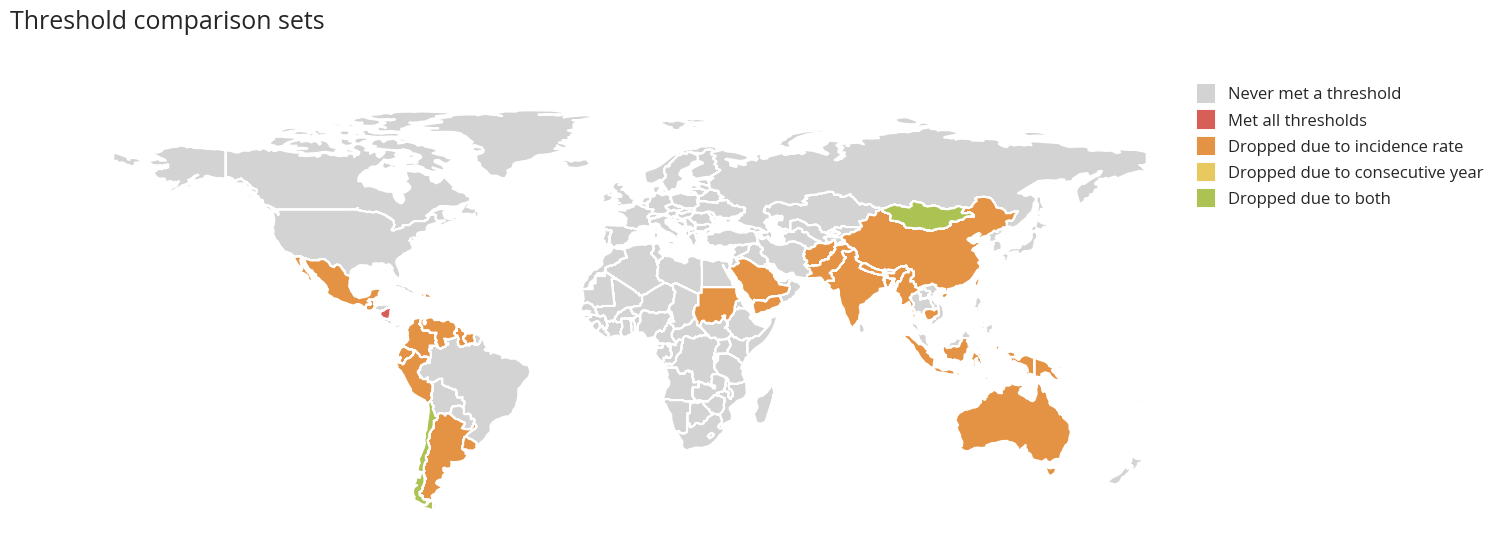

In [72]:
# Create a copy of the GeoDataFrame and merge with endemic countries
map_data = dengue_pop_geo.copy()
map_data['is_consistent'] = map_data['adm_0_iso3'].apply(lambda x: 1 if x in consistent_countries else 0)
map_data['ir_drop'] = map_data['adm_0_iso3'].apply(lambda x: 1 if x in primarily_threshold else 0)
map_data['consec_drop'] = map_data['adm_0_iso3'].apply(lambda x: 1 if x in primarily_years else 0)
map_data['both_drop'] = map_data['adm_0_iso3'].apply(lambda x: 1 if x in both_drops else 0)

map_data = gpd.GeoDataFrame(map_data, geometry='adm_0_geometry')

# Plot
fig, ax = plt.subplots(figsize=(16, 16))
map_data.plot(ax=ax, color='lightgrey', label='Never met a threshold')  

# Plot each category with its color and label
map_data[map_data['is_consistent'] == 1].plot(ax=ax, color=colors[7], label='Met all thresholds')  
map_data[map_data['ir_drop'] == 1].plot(ax=ax, color=colors[6], label='Dropped due to incidence rate')  
map_data[map_data['consec_drop'] == 1].plot(ax=ax, color=colors[5], label='Dropped due to consecutive year')  
map_data[map_data['both_drop'] == 1].plot(ax=ax, color=colors[4], label='Dropped due to both')  

# Set plot title and remove axes
ax.set_title(f"Threshold comparison sets", loc='left')
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])

# Add legend with custom patches
handles = [
    mpatches.Patch(color='lightgrey', label='Never met a threshold'),
    mpatches.Patch(color=colors[7], label='Met all thresholds'),
    mpatches.Patch(color=colors[6], label='Dropped due to incidence rate'),
    mpatches.Patch(color=colors[5], label='Dropped due to consecutive year'),
    mpatches.Patch(color=colors[4], label='Dropped due to both')
]
ax.legend(handles=handles, loc='upper right', bbox_to_anchor = (1.2,1))

# Save plot to file (optional)
# filename = f"../output/figures/thresholds/open_dengue_threshold_comparison_map.png"
# plt.savefig(filename, format='png', dpi=300, bbox_inches='tight')
plt.show()

#### Clustering

##### Plot - mean/var clusters on log(IR)

In [70]:
# Calculate mean and variance
k_data = dengue_pop.groupby('adm_0_iso3')['log_incidence_per_100k'].agg(['mean', 'var']).reset_index()

# Assign zero-incidence countries to a separate cluster
k_data['cluster'] = k_data['mean'].apply(lambda x: 0 if x == 0 else None)

# Feature Scaling for non-zero incidence countries
non_zero_k_data = k_data[k_data['mean'] > 0].copy()  

# Use both mean and variance as features for clustering
features = non_zero_k_data[['mean', 'var']]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)

# K-means Clustering on non-zero incidence countries
kmeans = KMeans(n_clusters=2, random_state=666)  
non_zero_k_data['cluster'] = kmeans.fit_predict(scaled_data) + 1  

# Check the means of each cluster to identify which is "low" and which is "high"
cluster_means = non_zero_k_data.groupby('cluster')['mean'].mean()
low_incidence_cluster = cluster_means.idxmin()  # The cluster with the lower mean is "low incidence"
high_incidence_cluster = cluster_means.idxmax()  # The cluster with the higher mean is "high incidence"

# Map clusters to "low" and "high" incidence labels
non_zero_k_data['cluster'] = non_zero_k_data['cluster'].map({
    low_incidence_cluster: 1,  # Relabel as 1 for "low incidence"
    high_incidence_cluster: 2  # Relabel as 2 for "high incidence"
})

# Merge back to main data (include 'adm_0_iso3' for merging)
k_data.update(non_zero_k_data[['adm_0_iso3', 'cluster']])


In [ ]:
# Define custom color mapping for clusters
cluster_palette = {0: colors[4], 1: colors[5], 2: colors[6]}  

# Define custom labels for clusters
legend_labels = ["No incidence", "Low incidence", "High incidence"]

# Plotting the clusters with specific color mapping
fig, ax = plt.subplots(figsize=(30, 6))
scatter = sns.scatterplot(data=k_data, x='adm_0_iso3', y='mean',
                          hue='cluster', palette=cluster_palette, s=100)

plt.title('K-means clustering of countries based on mean log(incidence rate per 100,000) and variance',loc='left',x=0)
plt.xlabel('Country')
plt.ylabel('mean log(IR)')

# Custom legend to ensure labels and colors align
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=legend_labels[i],
                              markerfacecolor=cluster_palette[i], markersize=10) for i in range(3)]
ax.legend(handles=legend_elements, title="Incidence clusters", bbox_to_anchor=(1, 1), loc='upper left')

# Set tick parameters
ax.tick_params(axis='x', pad=5, length=0, labelsize=8, width=30)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_xlim(left=-3.0, right=len(k_data['adm_0_iso3']))

ax.tick_params(axis='y', pad=10, width=30, labelsize=8)
plt.setp(ax.get_yticklabels(), rotation=0)
ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)

plt.tight_layout()

filename = f"../output/figures/thresholds/clusters/open_dengue_incidence_kmeans_clusters_mean_var.png"
plt.savefig(filename, format='png', dpi=300)
plt.close()

In [72]:
# Determine silhouette score 
non_zero_scaled_data = scaled_data  # We only need the non-zero data for clustering evaluation
sil_score = silhouette_score(non_zero_scaled_data, non_zero_k_data['cluster'])
print(f'Silhouette Score (for non-zero countries): {sil_score}','\n')

# Inspect the clusters and define endemicity categories
print(k_data.groupby('cluster').agg({'mean': ['min', 'max', 'mean']}),"\n")

for cluster_id, group in k_data.groupby('cluster'):
    countries = group['adm_0_iso3'].tolist()
    print(f"Cluster {cluster_id} - {len(countries)} countries: {', '.join(countries)}")


Silhouette Score (for non-zero countries): 0.5475212439807613 

             mean                    
              min       max      mean
cluster                              
0.0      0.000000  0.000000  0.000000
1.0      0.020168  1.263737  0.526864
2.0      1.007643  3.708090  2.111201 

Cluster 0.0 - 112 countries: AGO, ALB, ARE, ARM, AUT, AZE, BDI, BEL, BEN, BFA, BGR, BIH, BLR, BWA, CAF, CAN, CHE, CIV, CMR, COD, COG, CYP, CZE, DEU, DJI, DNK, DZA, EGY, ERI, ESP, EST, ETH, FIN, FLK, FRA, GAB, GBR, GEO, GHA, GIN, GMB, GNB, GNQ, GRC, GRL, HRV, HUN, IRL, IRN, IRQ, ISL, ISR, ITA, JOR, KAZ, KEN, KGZ, KOR, KWT, LBN, LBR, LBY, LSO, LTU, LUX, LVA, MAR, MDA, MDG, MKD, MLI, MNE, MOZ, MRT, MWI, NAM, NER, NGA, NLD, NOR, NZL, OMN, POL, PRK, PRT, QAT, ROU, RUS, RWA, SEN, SLE, SOM, SRB, SSD, SVK, SVN, SWE, SWZ, SYR, TCD, TGO, TJK, TKM, TUN, TUR, TZA, UGA, UKR, UZB, ZAF, ZMB, ZWE
Cluster 1.0 - 55 countries: ABW, AFG, AIA, ARG, ATG, AUS, BES, BGD, BHS, BLM, BMU, BRN, BTN, CHL, CHN, COL, CUB, CUW, 

##### Plot - mean/var clusters on 5 year rolling log(IR)

In [73]:
# Calculate mean and variance
kRoll_data = dengue_pop.groupby('adm_0_iso3')['rolling_mean_4yr'].agg(['mean', 'var']).reset_index()

# Assign zero-incidence countries to a separate cluster
kRoll_data['cluster'] = kRoll_data['mean'].apply(lambda x: 0 if x == 0 else None)

# Feature Scaling for non-zero incidence countries
non_zero_kRoll_data = kRoll_data[kRoll_data['mean'] > 0].copy()  

# Use both mean and variance as features for clustering
features = non_zero_kRoll_data[['mean', 'var']]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)

# K-means Clustering on non-zero incidence countries
kmeans = KMeans(n_clusters=2, random_state=666)  
non_zero_kRoll_data['cluster'] = kmeans.fit_predict(scaled_data) + 1  

# Check the means of each cluster to identify which is "low" and which is "high"
cluster_means = non_zero_kRoll_data.groupby('cluster')['mean'].mean()
low_incidence_cluster = cluster_means.idxmin()  # The cluster with the lower mean is "low incidence"
high_incidence_cluster = cluster_means.idxmax()  # The cluster with the higher mean is "high incidence"

# Map clusters to "low" and "high" incidence labels
non_zero_kRoll_data['cluster'] = non_zero_kRoll_data['cluster'].map({
    low_incidence_cluster: 1,  # Relabel as 1 for "low incidence"
    high_incidence_cluster: 2  # Relabel as 2 for "high incidence"
})

# Merge back to main data (include 'adm_0_iso3' for merging)
kRoll_data.update(non_zero_kRoll_data[['adm_0_iso3', 'cluster']])


In [ ]:
# Define custom color mapping for clusters
cluster_palette = {0: colors[4], 1: colors[5], 2: colors[6]}  

# Define custom labels for clusters
legend_labels = ["No incidence", "Low incidence", "High incidence"]

# Plotting the clusters with specific color mapping
fig, ax = plt.subplots(figsize=(30, 6))
scatter = sns.scatterplot(data=kRoll_data, x='adm_0_iso3', y='mean',
                          hue='cluster', palette=cluster_palette, s=100)

plt.title('K-means clustering of countries based on 4-year rolling mean log(incidence rate per 100,000) and variance',loc='left',x=0)
plt.xlabel('Country')
plt.ylabel('mean log(IR)')

# Custom legend to ensure labels and colors align
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=legend_labels[i],
                              markerfacecolor=cluster_palette[i], markersize=10) for i in range(3)]
ax.legend(handles=legend_elements, title="Incidence clusters", bbox_to_anchor=(1, 1), loc='upper left')

# Set tick parameters
ax.tick_params(axis='x', pad=5, length=0, labelsize=8, width=30)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_xlim(left=-3.0, right=len(k_data['adm_0_iso3']))

ax.tick_params(axis='y', pad=10, width=30, labelsize=8)
plt.setp(ax.get_yticklabels(), rotation=0)
ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)

plt.tight_layout()

filename = f"../output/figures/thresholds/clusters/open_dengue_incidence_kmeans_clusters_4yr_mean_var.png"
plt.savefig(filename, format='png', dpi=300)
plt.close()

In [75]:
# Determine silhouette score 
non_zero_scaled_data = scaled_data  # We only need the non-zero data for clustering evaluation
sil_score = silhouette_score(non_zero_scaled_data, non_zero_kRoll_data['cluster'])
print(f'Silhouette Score (for non-zero countries): {sil_score}','\n')

# Inspect the clusters and define endemicity categories
print(kRoll_data.groupby('cluster').agg({'mean': ['min', 'max', 'mean']}),"\n")

for cluster_id, group in kRoll_data.groupby('cluster'):
    countries = group['adm_0_iso3'].tolist()
    print(f"Cluster {cluster_id} - {len(countries)} countries: {', '.join(countries)}")

Silhouette Score (for non-zero countries): 0.6172339255871139 

             mean                    
              min       max      mean
cluster                              
0.0      0.000000  0.000000  0.000000
1.0      0.020168  1.347431  0.538670
2.0      0.986392  3.673402  2.116331 

Cluster 0.0 - 112 countries: AGO, ALB, ARE, ARM, AUT, AZE, BDI, BEL, BEN, BFA, BGR, BIH, BLR, BWA, CAF, CAN, CHE, CIV, CMR, COD, COG, CYP, CZE, DEU, DJI, DNK, DZA, EGY, ERI, ESP, EST, ETH, FIN, FLK, FRA, GAB, GBR, GEO, GHA, GIN, GMB, GNB, GNQ, GRC, GRL, HRV, HUN, IRL, IRN, IRQ, ISL, ISR, ITA, JOR, KAZ, KEN, KGZ, KOR, KWT, LBN, LBR, LBY, LSO, LTU, LUX, LVA, MAR, MDA, MDG, MKD, MLI, MNE, MOZ, MRT, MWI, NAM, NER, NGA, NLD, NOR, NZL, OMN, POL, PRK, PRT, QAT, ROU, RUS, RWA, SEN, SLE, SOM, SRB, SSD, SVK, SVN, SWE, SWZ, SYR, TCD, TGO, TJK, TKM, TUN, TUR, TZA, UGA, UKR, UZB, ZAF, ZMB, ZWE
Cluster 1.0 - 58 countries: ABW, AFG, AIA, ARG, ASM, ATG, AUS, BES, BGD, BHS, BLM, BMU, BRN, BTN, CHL, CHN, CUB, CUW, 

#### Map based on cluster

In [ ]:
dengue_pop_geo_cluster = dengue_pop_geo.merge(kRoll_data[['adm_0_iso3', 'cluster']], on='adm_0_iso3', how='left')
dengue_pop_geo_cluster['cluster'] = dengue_pop_geo_cluster['cluster'].fillna(0)
dengue_pop_geo_cluster = gpd.GeoDataFrame(dengue_pop_geo_cluster, geometry='adm_0_geometry')

# Define colors for each cluster
cluster_colors = {0: colors[4], 1: colors[5], 2: colors[6]}
dengue_pop_geo_cluster['color'] = dengue_pop_geo_cluster['cluster'].map(cluster_colors)

fig, ax = plt.subplots(figsize=(16, 16))

# Plot using the color column
dengue_pop_geo_cluster.plot(color=dengue_pop_geo_cluster['color'], ax=ax, legend=True, linewidth=0.5)

# Define the custom legend labels
legend_labels = ["No incidence", "Low incidence", "High incidence"]
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in cluster_colors.values()]
plt.legend(handles, legend_labels, title="Incidence levels", bbox_to_anchor=(0.95, 1), loc='upper left')

# Turn off the frame and ticks completely
ax.set_frame_on(False)  # Remove the frame
ax.set_xticks([])       # Remove x-axis ticks
ax.set_yticks([])       # Remove y-axis ticks

plt.tight_layout()

filename = f"../output/figures/thresholds/clusters/open_dengue_incidence_kmeans_clusters_4yr_mean_var_map.png"
plt.savefig(filename, format='png', dpi=300, bbox_inches='tight')
plt.close()

## Geocode

In [9]:
# # GEOCODE places (if needed)
#  user_agent = os.getenv("USER_AGENT")
# geolocator = Nominatim(user_agent=user_agent, timeout=10)

# # Load previously saved geocoded locations to avoid duplicates
# try:
#     with open('../data/cached_locations.pkl', 'rb') as f:
#         cached_locations = pickle.load(f)
# except (FileNotFoundError, EOFError):
#     cached_locations = {}

# def geocode_location(loc):
#     """Geocode the address if not already cached."""
#     if loc in cached_locations:
#         return cached_locations[loc]
#     else:
#         try:
#             location = geolocator.geocode(loc)
#             if location:
#                 # Only return latitude and longitude
#                 lat = location.latitude
#                 long = location.longitude
#                 lat_long = lat, long
#                 cached_locations[loc] = {
#                                     'latitude': lat,
#                                     'longitude': long,
#                                     'lat_long': lat_long
#                 }
#             else:
#                 cached_locations[loc] = None
#             # Save the cache after every new entry
#             with open('cached_locations.pkl', 'wb') as f:
#                 pickle.dump(cached_locations, f)
#             return cached_locations[loc]
#         except Exception as e:
#             print(f"Error geocoding {loc}: {e}")
#             return None

# locs = open_dengue["combined_place"]

# open_dengue["latitude"] = None
# open_dengue["longitude"] = None
# open_dengue["lat_long"] = None


# # Delay between requests in seconds to avoid hitting the rate limit
# REQUEST_DELAY = 0

# # Geocode locations with rate limiting and caching
# for idx, loc in enumerate(locs):
#     coords = geocode_location(loc)
    
#     if coords:
#         open_dengue.at[idx, "latitude"] = coords['latitude']
#         open_dengue.at[idx, "longitude"] = coords['longitude']
#         open_dengue.at[idx, "lat_long"] = coords['lat_long']
#         print(f"Address: {loc}, Coordinates: {coords}")
#     else:
#         print(f"Address: {loc}, Coordinates: Not found")
    
#     # Introduce delay to avoid API rate limits
#     time.sleep(REQUEST_DELAY)